# Сравнение методов визуализации данных

#### Карпова Анастасия (БЭК 165), Омелюсик Владимир (БЭК 161)

В этой тетрадке приведён код к статье, который генерирует использованные в ней изображения. Проекции `TMAP` не сохраняются при закрытии тетрадки, поэтому чтобы увидеть их, требуется запустить соответствующие клетки заново при каждом запуске. 

----

In [ ]:
# Установка библиотек в Jupyter / Colab
!pip install git+https://github.com/samueljackson92/coranking.git

In [ ]:
!conda install -c tmap tmap

In [ ]:
! pip install faerun

In [ ]:
! conda install -c conda-forge umap-learn

In [52]:
# Техническое
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn import datasets
from sklearn import manifold
import time
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.model_selection import train_test_split

# Методы понижения размерности
from sklearn.manifold import Isomap, TSNE, MDS
import umap.umap_ as umap # https://github.com/lmcinnes/umap/issues/24
from sklearn.manifold import LocallyLinearEmbedding as lle
import tmap as tm
from faerun import Faerun

# Метрики
import coranking
from coranking.metrics import trustworthiness, continuity, LCMC

In [32]:
plt.rcParams["image.cmap"] = "tab20"

In [2]:
np.random.seed(10)

### Swissroll

#### 3D-изображение

In [3]:
swissroll, swissroll_labels = datasets.make_swiss_roll(
    n_samples=1000, noise=0.1, random_state=42)

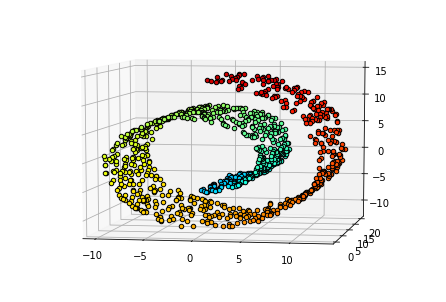

In [59]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(swissroll_labels):
    ax.scatter(swissroll[swissroll_labels == l, 0], swissroll[swissroll_labels == l, 1], swissroll[swissroll_labels == l, 2],
               color=plt.cm.jet(np.float(l) / np.max(swissroll_labels + 1)),
               s=20, edgecolor='k')
plt.show()

#### MDS

In [8]:
# Реализован метрический и неметрический, основанный на расстояниях (НЕ классический)
start_time = time.time()
mds = MDS(n_components=2)
embedding_sw_mds = mds.fit_transform(swissroll)
dur_mds = time.time() - start_time
print("--- %s seconds ---" % (dur_mds))

--- 58.8716356754303 seconds ---


#### Isomap

In [9]:
start_time = time.time()
emb_isomap_sw = Isomap(30, 2).fit_transform(swissroll)
dur_isomap_sw = time.time() - start_time
print("--- %s seconds ---" % (dur_isomap_sw))

--- 1.1919541358947754 seconds ---


#### LLE

In [10]:
start_time = time.time()
emb_lle_sw = lle(n_neighbors = 10, n_components = 2).fit_transform(swissroll)
dur_lle_sw = time.time() - start_time
print("--- %s seconds ---" % (dur_lle_sw))

--- 0.5397980213165283 seconds ---


#### t-SNE

In [11]:
start_time = time.time()
emb_tsne_sw = TSNE(n_components = 2).fit_transform(swissroll)
dur_tsne_sw = time.time() - start_time
print("--- %s seconds ---" % (dur_tsne_sw))

--- 8.375810861587524 seconds ---


#### UMAP

In [12]:
start_time = time.time()
embedding_sw = umap.UMAP(n_neighbors=30).fit_transform(swissroll)
dur_umap = time.time() - start_time
print("--- %s seconds ---" % (dur_umap))

--- 14.766383647918701 seconds ---


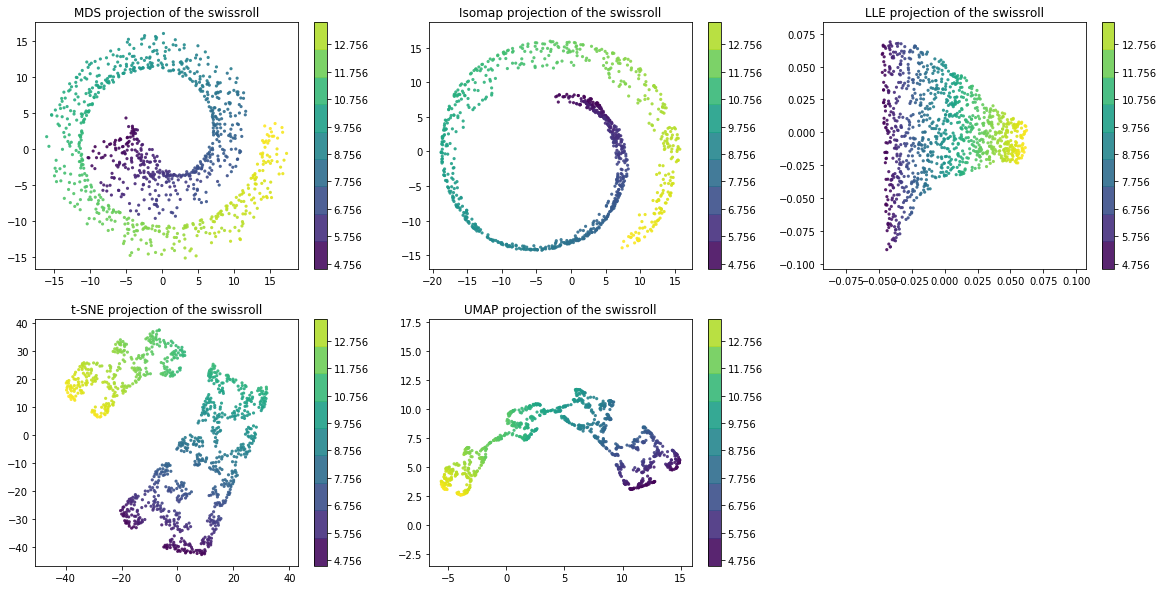

In [68]:
projectors = [embedding_sw_mds, emb_isomap_sw, emb_lle_sw, emb_tsne_sw, embedding_sw]
plt.rcParams["image.cmap"] = "viridis"
names = ['MDS', 'Isomap', 'LLE', 't-SNE', 'UMAP']
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
#plt.subplots_adjust(hspace = 0.9)

i = 1
for proj in projectors:
    ax = fig.add_subplot(2, 3, i)
    plt.scatter(proj[:, 0], proj[:, 1], 
            c=swissroll_labels, 
            edgecolor='none', 
            alpha=0.90,  
            s=10)
    plt.gca().set_aspect('equal', 'datalim')
    cbar = plt.colorbar(boundaries=np.arange(np.min(swissroll_labels), np.max(swissroll_labels))-0.2)
    cbar.set_ticks(np.arange(np.min(swissroll_labels), np.max(swissroll_labels)))
    tlt = names[i-1] + ' projection of the swissroll'
    plt.title(tlt)
    i += 1

#### TMAP

In [4]:
# http://tmap.gdb.tools/#ex-coil

import tmap as tm

# Coniguration for the tmap layout
CFG = tm.LayoutConfiguration()
CFG.node_size = 1 / 50

# Initialize and configure tmap
enc = tm.Minhash()
lf = tm.LSHForest()

# Кодирование объектов
coded = []
for i in range(swissroll.shape[0]):
    coded.append(tm.VectorFloat(list(swissroll[i, :])))

start_time = time.time()
lf.batch_add(enc.batch_from_weight_array(coded))
lf.index()

x, y, s, t, _ = tm.layout_from_lsh_forest(lf, CFG)

dur_tmap = time.time() - start_time
print("--- %s seconds ---" % (dur_tmap))

lf.clear()

# Create the plot
faerun = Faerun(view="front", coords=False, legend_title="Swissroll")
faerun.add_scatter(
    "swr",
    {"x": x, "y": y, "c": swissroll_labels, "labels": swissroll_labels},
    colormap="viridis",
    point_scale=5.0,
    max_point_size=10,
    shader="smoothCircle",
    has_legend=True,
    categorical=False,
    )
faerun.add_tree(
    "swr_tree", {"from": s, "to": t}, point_helper="swr", color="#666666"
)
faerun.plot("swr")

--- 2.015028238296509 seconds ---


/home/vladimiromelyusik/machine_learning_hse_all/ml_fcs/Project/swr.html

#### Метрики качества

In [35]:
def plot_metrics(dataset, embedding_list, methods):
    '''
    dataset -- dataset to calculate on
    embedding_list -- list of embeddings from models
    methods — list of methods
    '''
    names = methods
    i = 0
    trusts = []
    conts = []
    lcmcs = []
    
    for embedding in embedding_list:
        Q = coranking.coranking_matrix(dataset, embedding)
        trusts.append(trustworthiness(Q, min_k = 1, max_k = 50))
        conts.append(continuity(Q, min_k = 1, max_k = 50))
        lcmcs.append(LCMC(Q, min_k = 1, max_k = 50))
        
    metrics = [trusts, conts, lcmcs]
    fig = plt.figure()
    #fig.set_figheight(10)
    fig.set_figwidth(20)
    #plt.subplots_adjust(hspace = 0.9)
    
    i = 1    
    for metric in metrics:
        ax = fig.add_subplot(1, 3, i)
        if i == 1:
            plt.ylabel('Trustworthinness')
        elif i == 2:
            plt.ylabel('Continuity')
        elif i == 3:
            plt.ylabel('LCMC')
            
        for j in range(len(metric)):
            ax = plt.plot(np.arange(49), metric[j], label = names[j])
            plt.legend()
        i += 1
        

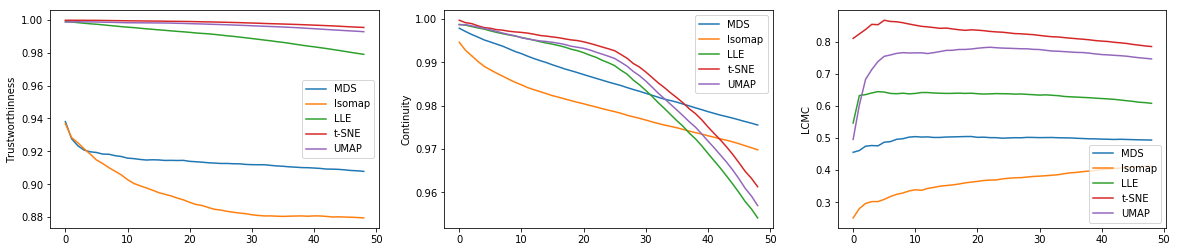

In [72]:
meth =  ['MDS', 'Isomap', 'LLE', 't-SNE', 'UMAP']
plot_metrics(swissroll, [embedding_sw_mds, emb_isomap_sw, emb_lle_sw, emb_tsne_sw, embedding_sw], meth)

### FASHION MNIST

https://www.kaggle.com/mtax687/explorations-of-fashion-mnist-dataset

In [85]:
#data_train = pd.read_csv('/home/vladimiromelyusik/fashionmnist/fashion-mnist_train.csv')
data_train = pd.read_csv('fashion-mnist_train.csv')

In [86]:
X_train, X_test, y_train, y_test = train_test_split(data_train.iloc[:,1:], data_train.iloc[:,0], test_size=0.05)

In [87]:
X_test_stand = StandardScaler().fit_transform(X_test)
X_test_norm = Normalizer().fit_transform(X_test_stand)

/home/vladimiromelyusik/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vladimiromelyusik/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [88]:
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

#### MDS

In [14]:
start_time = time.time()
mds = MDS(n_components=2)
embedding_fmnist_mds = mds.fit_transform(X_test_norm)
dur_mds = time.time() - start_time
print("--- %s seconds ---" % (dur_mds))

--- 1001.6728353500366 seconds ---


#### Isomap

In [15]:
start_time = time.time()
emb_isomap = Isomap(50, 2).fit_transform(X_test_norm)
dur_isomap = time.time() - start_time
print("--- %s seconds ---" % (dur_isomap))

--- 42.51373529434204 seconds ---


#### LLE

In [16]:
start_time = time.time()
emb_lle = lle(n_neighbors = 12, n_components = 2).fit_transform(X_test_norm)
dur_lle = time.time() - start_time
print("--- %s seconds ---" % (dur_lle))

--- 21.72556233406067 seconds ---


#### t-SNE

In [17]:
start_time = time.time()
emb_tsne_fm = TSNE(n_components = 2).fit_transform(X_test_norm)
dur_tsne_fm = time.time() - start_time
print("--- %s seconds ---" % (dur_tsne_fm))

--- 52.01653599739075 seconds ---


#### UMAP

In [9]:
start_time = time.time()
emb_umap = umap.UMAP(n_neighbors=10).fit_transform(X_test_norm)
dur_umap = time.time() - start_time
print("--- %s seconds ---" % (dur_umap))

--- 18.229682207107544 seconds ---


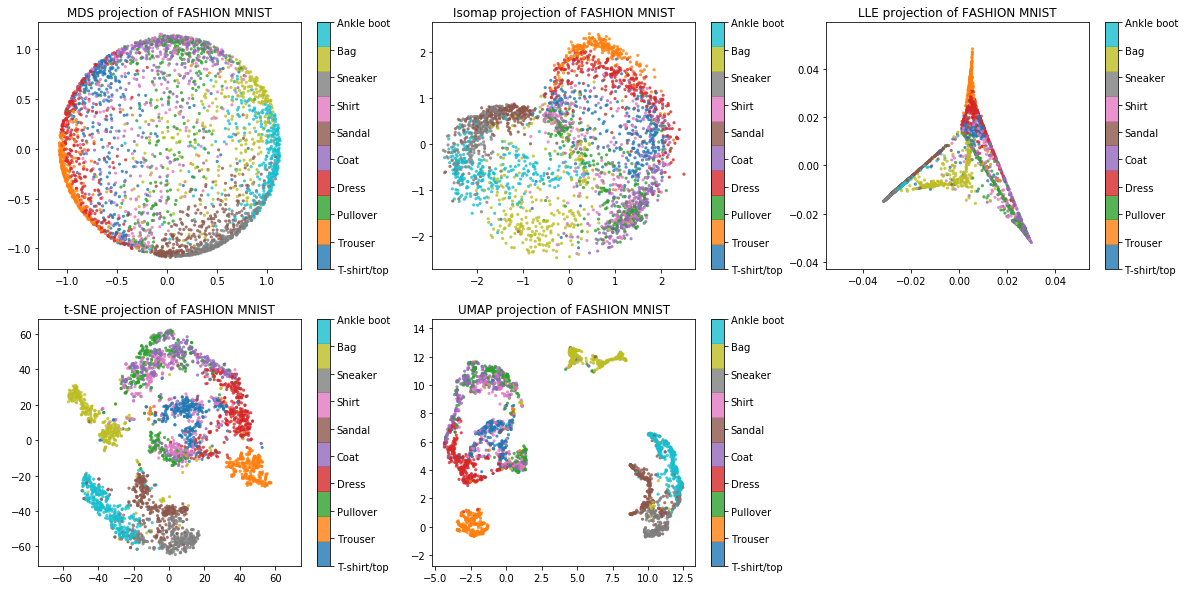

In [41]:
projectors = [embedding_fmnist_mds, emb_isomap, emb_lle, emb_tsne_fm, emb_umap]
names = ['MDS', 'Isomap', 'LLE', 't-SNE', 'UMAP']
plt.rcParams["image.cmap"] = "tab10"
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
#plt.subplots_adjust(hspace = 0.9)

i = 1
for proj in projectors:
    ax = fig.add_subplot(2, 3, i)
    plt.scatter(proj[:, 0], proj[:, 1], 
            c=y_test, 
            edgecolor='none', 
            alpha=0.80, 
            s=10)
    plt.gca().set_aspect('equal', 'datalim')
    cbar = plt.colorbar()#boundaries=np.arange(10)-0.2)
    cbar.set_ticks(np.arange(10))
    cbar.set_ticklabels(classes)
    tlt = names[i-1] + ' projection of FASHION MNIST'
    plt.title(tlt)
    i += 1

#### Метрики качества

In [27]:
meth = ['MDS', 'Isomap', 'LLE', 't-SNE', 'UMAP']

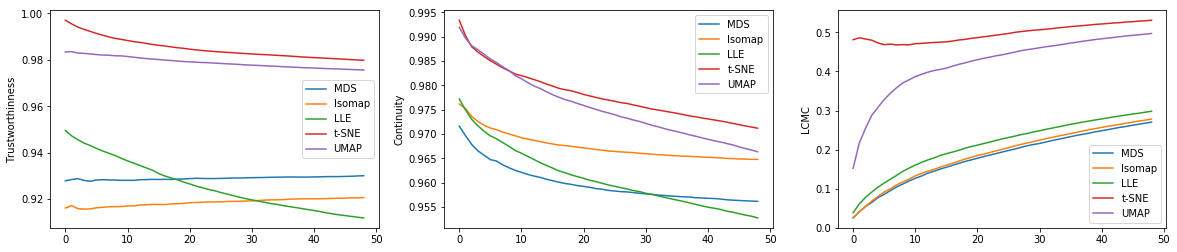

In [30]:
plot_metrics(X_test_norm, [embedding_fmnist_mds, emb_isomap, emb_lle, emb_tsne_fm, emb_umap], meth)

#### Сравнение гиперпараметров

На данных Fashion MNIST посмотрим, как качество визуализации может отличаться в зависимости от заданных гиперпараметров.

Так как MDS в этой компании кажется бесспорным аутсайдером, не будем тратить время и терпение на тестирование его гиперпараметров.

Для всех методов рассмотрим параметр n_neighbors (для t-SNE — perplexity), регулирующий число соседей в окрестности многообразия для каждой точки.

In [65]:
plt.rcParams["image.cmap"] = "tab20"

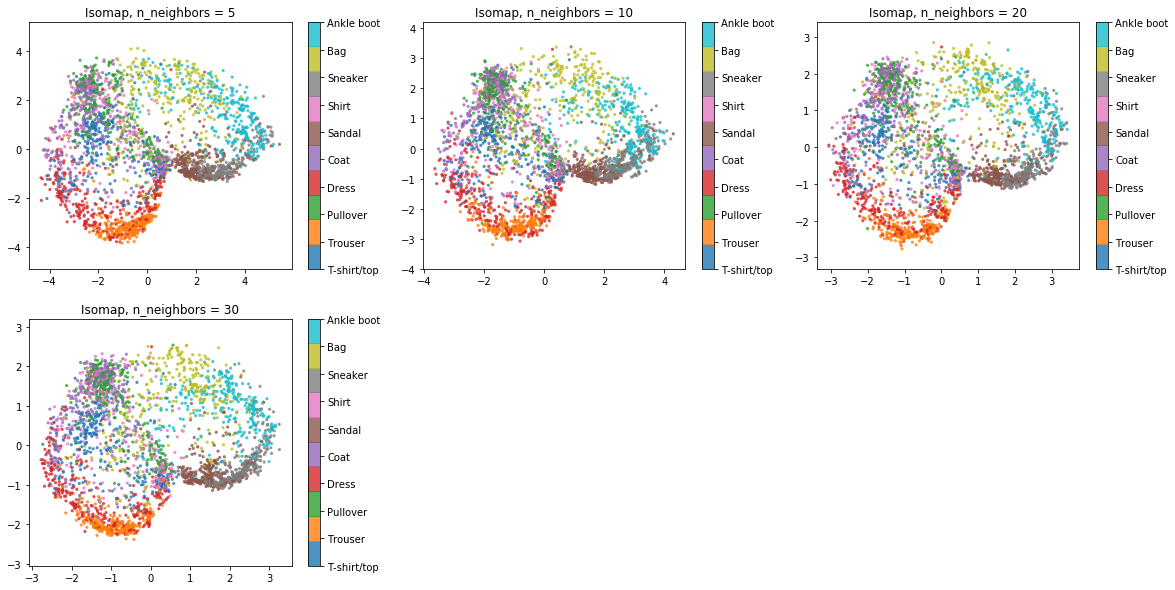

In [8]:
n_neighb = [5, 10, 20, 30]

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)

i = 1
for n in n_neighb:
    emb_isomap = Isomap(n_neighbors=n).fit_transform(X_test_norm)
    ax = fig.add_subplot(2, 3, i)
    plt.scatter(emb_isomap[:, 0], emb_isomap[:, 1], 
            c=y_test, 
            edgecolor='none', 
            alpha=0.80, 
            s=10)
    plt.gca().set_aspect('equal', 'datalim')
    cbar = plt.colorbar()#boundaries=np.arange(10)-0.2)
    cbar.set_ticks(np.arange(10))
    cbar.set_ticklabels(classes)
    tlt = 'Isomap, n_neighbors = {}'.format(n)
    plt.title(tlt)
    i += 1

Isomap показывает константное качество для всех значений гиперпараметра.
Художественные возможности алгоритма поражают, но границы классов остаются размытыми.

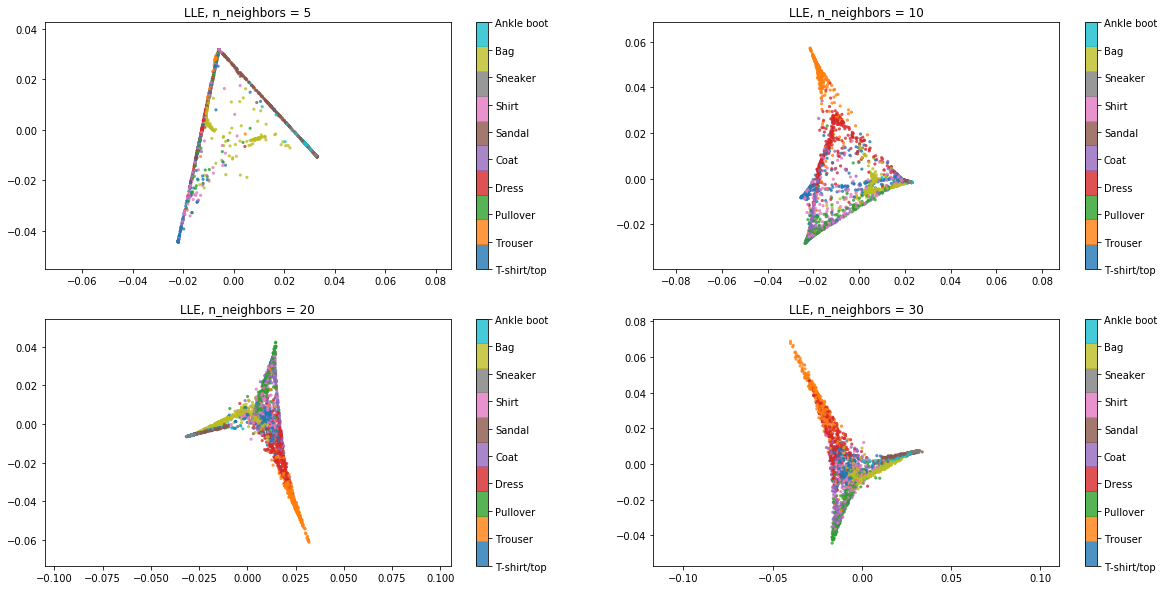

In [9]:
n_neighb = [5, 10, 20, 30]

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)

i = 1
for n in n_neighb:
    emb_lle = lle(n_neighbors=n).fit_transform(X_test_norm)
    ax = fig.add_subplot(2, 2, i)
    plt.scatter(emb_lle[:, 0], emb_lle[:, 1], 
            c=y_test, 
            edgecolor='none', 
            alpha=0.80, 
            s=10)
    plt.gca().set_aspect('equal', 'datalim')
    cbar = plt.colorbar()#boundaries=np.arange(10)-0.2)
    cbar.set_ticks(np.arange(10))
    cbar.set_ticklabels(classes)
    tlt = 'LLE, n_neighbors = {}'.format(n)
    plt.title(tlt)
    i += 1

Качество визуализации явно растет с ростом значения параметра.
Данные хорошо группируются по кластерам, однако все кластеры находятся близко друг к другу.

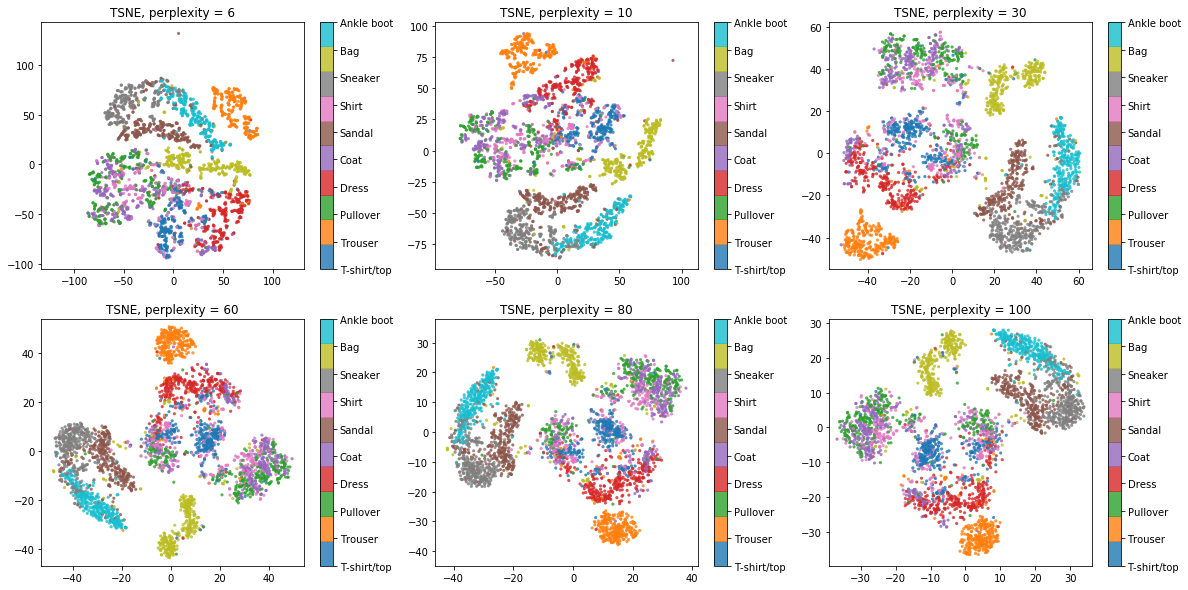

In [10]:
perpl = [6, 10, 30, 60, 80, 100]

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)

i = 1
for p in perpl:
    emb_tsne = TSNE(perplexity=p).fit_transform(X_test_norm)
    ax = fig.add_subplot(2, 3, i)
    plt.scatter(emb_tsne[:, 0], emb_tsne[:, 1], 
            c=y_test, 
            edgecolor='none', 
            alpha=0.80, 
            s=10)
    plt.gca().set_aspect('equal', 'datalim')
    cbar = plt.colorbar()#boundaries=np.arange(10)-0.2)
    cbar.set_ticks(np.arange(10))
    cbar.set_ticklabels(classes)
    tlt = 'TSNE, perplexity = {}'.format(p)
    plt.title(tlt)
    i += 1

Видим, что при больших значениях `perplexity` классы отдельных видов одежды отстаят друг от друга дальше.

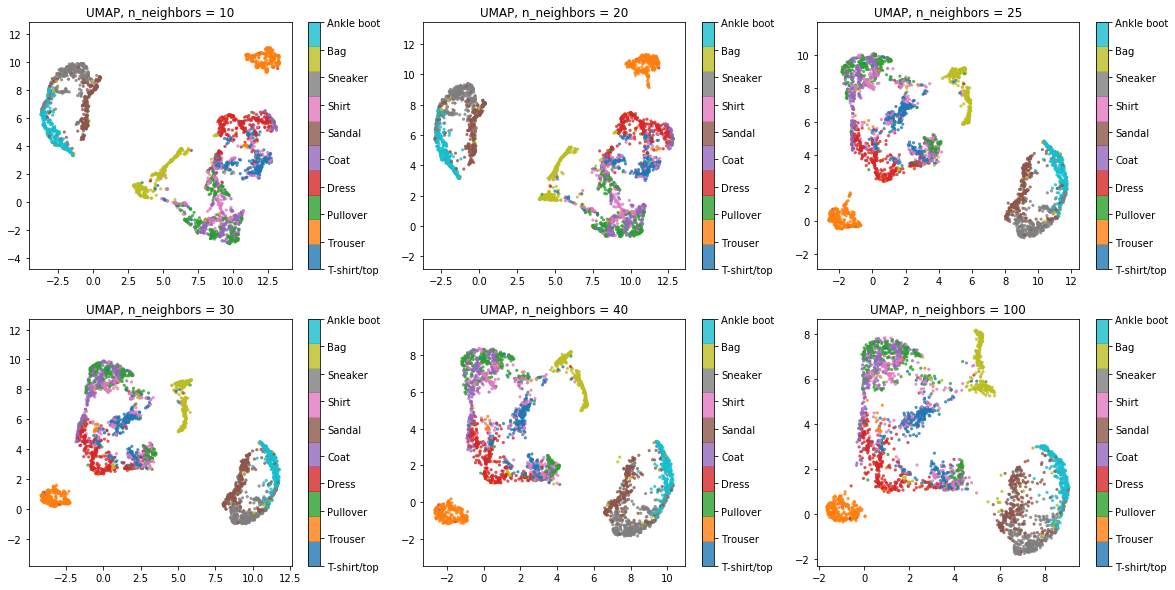

In [11]:
n_neighb = [10, 20, 25, 30, 40, 100]

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)

i = 1
for n in n_neighb:
    emb_umap = umap.UMAP(n_neighbors=n).fit_transform(X_test_norm)
    ax = fig.add_subplot(2, 3, i)
    plt.scatter(emb_umap[:, 0], emb_umap[:, 1], 
            c=y_test, 
            edgecolor='none', 
            alpha=0.80, 
            s=10)
    plt.gca().set_aspect('equal', 'datalim')
    cbar = plt.colorbar()#boundaries=np.arange(10)-0.2)
    cbar.set_ticks(np.arange(10))
    cbar.set_ticklabels(classes)
    tlt = 'UMAP, n_neighbors = {}'.format(n)
    plt.title(tlt)
    i += 1

На глаз кажется, что значимых улучшений при различных значениях параметра нет.
При маленьком значение параметра ($n<20$) отдельные классы близко располагаются друг к другу.

#### TMAP

In [42]:
# http://tmap.gdb.tools/#ex-fmnist

import base64
from io import BytesIO
from timeit import default_timer as timer
from PIL import Image

# Coniguration for the tmap layout
CFG = tm.LayoutConfiguration()
CFG.node_size = 1 / 55

# Initialize and configure tmap
dims = 1024
enc = tm.Minhash(28 * 28, 42, dims)
lf = tm.LSHForest(dims * 2, 128)

IMAGE_LABELS = []

print("Converting images ...")
for i in range(X_test.shape[0]):
    img = Image.fromarray(np.uint8(np.split(X_test.iloc[i, :], 28)))
    buffered = BytesIO()
    img.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue())
    IMAGE_LABELS.append(
        "data:image/bmp;base64," + str(img_str).replace("b'", "").replace("'", "")
    )

# 1. Кодирование объектов
coded = []
for i in range(X_test.shape[0]):
    coded.append(tm.VectorFloat(list(X_test_norm[i, :])))

print("Running tmap ...")
start = timer()
lf.batch_add(enc.batch_from_weight_array(coded))
lf.index()
x, y, s, t, _ = tm.layout_from_lsh_forest(lf, CFG)
print("tmap: " + str(timer() - start))

legend_labels = [
    (0, "T-shirt/top"),
    (1, "Trouser"),
    (2, "Pullover"),
    (3, "Dress"),
    (4, "Coat"),
    (5, "Sandal"),
    (6, "Shirt"),
    (7, "Sneaker"),
    (8, "Bag"),
    (9, "Ankle boot"),
]

faerun = Faerun(clear_color="#111111", view="front", coords=False)
faerun.add_scatter(
    "FMNIST",
    {"x": x, "y": y, "c": list(y_test), "labels": IMAGE_LABELS},
    colormap="tab10",
    shader="smoothCircle",
    point_scale=2.5,
    max_point_size=10,
    has_legend=True,
    categorical=True,
    legend_labels=legend_labels,
)
faerun.add_tree(
    "FMNIST_tree", {"from": s, "to": t}, point_helper="FMNIST", color="#666666"
)
faerun.plot("fmnist", template="url_image")

Converting images ...
Running tmap ...
tmap: 24.966327000000092


/home/vladimiromelyusik/machine_learning_hse_all/ml_fcs/Project/fmnist.html

In [89]:
# http://tmap.gdb.tools/#ex-fmnist
# Меньший размер векторов MinHash

import base64
from io import BytesIO
from timeit import default_timer as timer
from PIL import Image

# Coniguration for the tmap layout
CFG = tm.LayoutConfiguration()
CFG.node_size = 1 / 55

# Initialize and configure tmap
dims = 512
enc = tm.Minhash(28 * 28, 42, dims)
lf = tm.LSHForest(dims * 2, 128)

IMAGE_LABELS = []

print("Converting images ...")
for i in range(X_test.shape[0]):
    img = Image.fromarray(np.uint8(np.split(X_test.iloc[i, :], 28)))
    buffered = BytesIO()
    img.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue())
    IMAGE_LABELS.append(
        "data:image/bmp;base64," + str(img_str).replace("b'", "").replace("'", "")
    )

# 1. Кодирование объектов
coded = []
for i in range(X_test.shape[0]):
    coded.append(tm.VectorFloat(list(X_test_norm[i, :])))

print("Running tmap ...")
start = timer()
lf.batch_add(enc.batch_from_weight_array(coded))
lf.index()
x, y, s, t, _ = tm.layout_from_lsh_forest(lf, CFG)
print("tmap: " + str(timer() - start))

legend_labels = [
    (0, "T-shirt/top"),
    (1, "Trouser"),
    (2, "Pullover"),
    (3, "Dress"),
    (4, "Coat"),
    (5, "Sandal"),
    (6, "Shirt"),
    (7, "Sneaker"),
    (8, "Bag"),
    (9, "Ankle boot"),
]

faerun = Faerun(clear_color="#111111", view="front", coords=False)
faerun.add_scatter(
    "FMNIST",
    {"x": x, "y": y, "c": list(y_test), "labels": IMAGE_LABELS},
    colormap="tab10",
    shader="smoothCircle",
    point_scale=2.5,
    max_point_size=10,
    has_legend=True,
    categorical=True,
    legend_labels=legend_labels,
)
faerun.add_tree(
    "FMNIST_tree", {"from": s, "to": t}, point_helper="FMNIST", color="#666666"
)
faerun.plot("fmnist", template="url_image")

Converting images ...
Running tmap ...
tmap: 15.377150000000256


/home/vladimiromelyusik/machine_learning_hse_all/ml_fcs/Project/fmnist.html

In [90]:
# http://tmap.gdb.tools/#ex-fmnist
# Больший размер векторов MinHash

import base64
from io import BytesIO
from timeit import default_timer as timer
from PIL import Image

# Coniguration for the tmap layout
CFG = tm.LayoutConfiguration()
CFG.node_size = 1 / 55

# Initialize and configure tmap
dims = 2048
enc = tm.Minhash(28 * 28, 42, dims)
lf = tm.LSHForest(dims * 2, 128)

IMAGE_LABELS = []

print("Converting images ...")
for i in range(X_test.shape[0]):
    img = Image.fromarray(np.uint8(np.split(X_test.iloc[i, :], 28)))
    buffered = BytesIO()
    img.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue())
    IMAGE_LABELS.append(
        "data:image/bmp;base64," + str(img_str).replace("b'", "").replace("'", "")
    )

# 1. Кодирование объектов
coded = []
for i in range(X_test.shape[0]):
    coded.append(tm.VectorFloat(list(X_test_norm[i, :])))

print("Running tmap ...")
start = timer()
lf.batch_add(enc.batch_from_weight_array(coded))
lf.index()
x, y, s, t, _ = tm.layout_from_lsh_forest(lf, CFG)
print("tmap: " + str(timer() - start))

legend_labels = [
    (0, "T-shirt/top"),
    (1, "Trouser"),
    (2, "Pullover"),
    (3, "Dress"),
    (4, "Coat"),
    (5, "Sandal"),
    (6, "Shirt"),
    (7, "Sneaker"),
    (8, "Bag"),
    (9, "Ankle boot"),
]

faerun = Faerun(clear_color="#111111", view="front", coords=False)
faerun.add_scatter(
    "FMNIST",
    {"x": x, "y": y, "c": list(y_test), "labels": IMAGE_LABELS},
    colormap="tab10",
    shader="smoothCircle",
    point_scale=2.5,
    max_point_size=10,
    has_legend=True,
    categorical=True,
    legend_labels=legend_labels,
)
faerun.add_tree(
    "FMNIST_tree", {"from": s, "to": t}, point_helper="FMNIST", color="#666666"
)
faerun.plot("fmnist", template="url_image")

Converting images ...
Running tmap ...
tmap: 65.85813960000087


/home/vladimiromelyusik/machine_learning_hse_all/ml_fcs/Project/fmnist.html

In [91]:
# http://tmap.gdb.tools/#ex-fmnist
# Больше префиксных деревьев

import base64
from io import BytesIO
from timeit import default_timer as timer
from PIL import Image

# Coniguration for the tmap layout
CFG = tm.LayoutConfiguration()
CFG.node_size = 1 / 55

# Initialize and configure tmap
dims = 1024
enc = tm.Minhash(28 * 28, 42, dims)
lf = tm.LSHForest(dims * 2, 256)

IMAGE_LABELS = []

print("Converting images ...")
for i in range(X_test.shape[0]):
    img = Image.fromarray(np.uint8(np.split(X_test.iloc[i, :], 28)))
    buffered = BytesIO()
    img.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue())
    IMAGE_LABELS.append(
        "data:image/bmp;base64," + str(img_str).replace("b'", "").replace("'", "")
    )

# 1. Кодирование объектов
coded = []
for i in range(X_test.shape[0]):
    coded.append(tm.VectorFloat(list(X_test_norm[i, :])))

print("Running tmap ...")
start = timer()
lf.batch_add(enc.batch_from_weight_array(coded))
lf.index()
x, y, s, t, _ = tm.layout_from_lsh_forest(lf, CFG)
print("tmap: " + str(timer() - start))

legend_labels = [
    (0, "T-shirt/top"),
    (1, "Trouser"),
    (2, "Pullover"),
    (3, "Dress"),
    (4, "Coat"),
    (5, "Sandal"),
    (6, "Shirt"),
    (7, "Sneaker"),
    (8, "Bag"),
    (9, "Ankle boot"),
]

faerun = Faerun(clear_color="#111111", view="front", coords=False)
faerun.add_scatter(
    "FMNIST",
    {"x": x, "y": y, "c": list(y_test), "labels": IMAGE_LABELS},
    colormap="tab10",
    shader="smoothCircle",
    point_scale=2.5,
    max_point_size=10,
    has_legend=True,
    categorical=True,
    legend_labels=legend_labels,
)
faerun.add_tree(
    "FMNIST_tree", {"from": s, "to": t}, point_helper="FMNIST", color="#666666"
)
faerun.plot("fmnist", template="url_image")

Converting images ...
Running tmap ...
tmap: 26.024167199997464


/home/vladimiromelyusik/machine_learning_hse_all/ml_fcs/Project/fmnist.html

In [92]:
# http://tmap.gdb.tools/#ex-fmnist
# Меньше префиксных деревьев

import base64
from io import BytesIO
from timeit import default_timer as timer
from PIL import Image

# Coniguration for the tmap layout
CFG = tm.LayoutConfiguration()
CFG.node_size = 1 / 55

# Initialize and configure tmap
dims = 1024
enc = tm.Minhash(28 * 28, 42, dims)
lf = tm.LSHForest(dims * 2, 64)

IMAGE_LABELS = []

print("Converting images ...")
for i in range(X_test.shape[0]):
    img = Image.fromarray(np.uint8(np.split(X_test.iloc[i, :], 28)))
    buffered = BytesIO()
    img.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue())
    IMAGE_LABELS.append(
        "data:image/bmp;base64," + str(img_str).replace("b'", "").replace("'", "")
    )

# 1. Кодирование объектов
coded = []
for i in range(X_test.shape[0]):
    coded.append(tm.VectorFloat(list(X_test_norm[i, :])))

print("Running tmap ...")
start = timer()
lf.batch_add(enc.batch_from_weight_array(coded))
lf.index()
x, y, s, t, _ = tm.layout_from_lsh_forest(lf, CFG)
print("tmap: " + str(timer() - start))

legend_labels = [
    (0, "T-shirt/top"),
    (1, "Trouser"),
    (2, "Pullover"),
    (3, "Dress"),
    (4, "Coat"),
    (5, "Sandal"),
    (6, "Shirt"),
    (7, "Sneaker"),
    (8, "Bag"),
    (9, "Ankle boot"),
]

faerun = Faerun(clear_color="#111111", view="front", coords=False)
faerun.add_scatter(
    "FMNIST",
    {"x": x, "y": y, "c": list(y_test), "labels": IMAGE_LABELS},
    colormap="tab10",
    shader="smoothCircle",
    point_scale=2.5,
    max_point_size=10,
    has_legend=True,
    categorical=True,
    legend_labels=legend_labels,
)
faerun.add_tree(
    "FMNIST_tree", {"from": s, "to": t}, point_helper="FMNIST", color="#666666"
)
faerun.plot("fmnist", template="url_image")

Converting images ...
Running tmap ...
tmap: 66.468389200003


/home/vladimiromelyusik/machine_learning_hse_all/ml_fcs/Project/fmnist.html

### News Aggregator 2014

#### Кодировка с помощью TF-IDF

In [83]:
news = pd.read_csv('uci-news-aggregator.csv')
texts = news['TITLE']

In [84]:
texts.shape

(422419,)

In [44]:
# Возьмём небольшое подмножество данных, так как даже на 5 тыс. объектах обучается долго
inds = np.random.randint(0, texts.shape[0], 1000)
texts_shrinked = texts[inds]

In [45]:
texts_shrinked.shape

(1000,)

In [46]:
# Предобработка (лемматизируем и убираем стоп-слова)
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

texts_good = []

regex = re.compile('[^a-z A-Z]') # Оставляет все слова, в которых только буквы
for doc in list(texts_shrinked):
    doc = doc.lower()
    doc = regex.sub('', doc)
    doc = " ".join([lemmatizer.lemmatize(token) for token in doc.split(' ') if not token in stopwords.words('english')]).strip()  
    texts_good.append(doc)

In [47]:
# Применяем TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
texts_tfidf = tfidf.fit_transform(texts_good)

In [48]:
texts_tfidf.shape

(1000, 3289)

#### MDS

In [49]:
start_time = time.time()
mds = MDS(n_components=2)
embedding_t_mds = mds.fit_transform(texts_tfidf.toarray())
dur_mds = time.time() - start_time
print("--- %s seconds ---" % (dur_mds))

--- 22.200794458389282 seconds ---


#### Isomap

In [50]:
start_time = time.time()
emb_isomap_t = Isomap(30, 2).fit_transform(texts_tfidf.toarray())
dur_isomap_t = time.time() - start_time
print("--- %s seconds ---" % (dur_isomap_t))

--- 13.409051179885864 seconds ---


#### LLE

In [51]:
start_time = time.time()
emb_lle_t = lle(n_neighbors = 10, n_components = 2).fit_transform(texts_tfidf.toarray())
dur_lle_t = time.time() - start_time
print("--- %s seconds ---" % (dur_lle_t))

--- 13.295511722564697 seconds ---


#### t-SNE

In [52]:
start_time = time.time()
emb_tsne_t = TSNE(n_components = 2).fit_transform(texts_tfidf.toarray())
dur_tsne_t = time.time() - start_time
print("--- %s seconds ---" % (dur_tsne_t))

--- 21.78715443611145 seconds ---


#### UMAP

In [53]:
start_time = time.time()
emb_umap = umap.UMAP(n_neighbors=10).fit_transform(texts_tfidf.toarray())
dur_umap = time.time() - start_time
print("--- %s seconds ---" % (dur_umap))

--- 5.973347902297974 seconds ---


In [79]:
keys = news['CATEGORY'][inds]
colors = np.zeros(len(keys))
colors[keys == 'b'] = 0
colors[keys == 'e'] = 1
colors[keys == 'm'] = 2
colors[keys == 't'] = 3
colors = colors.astype('int')

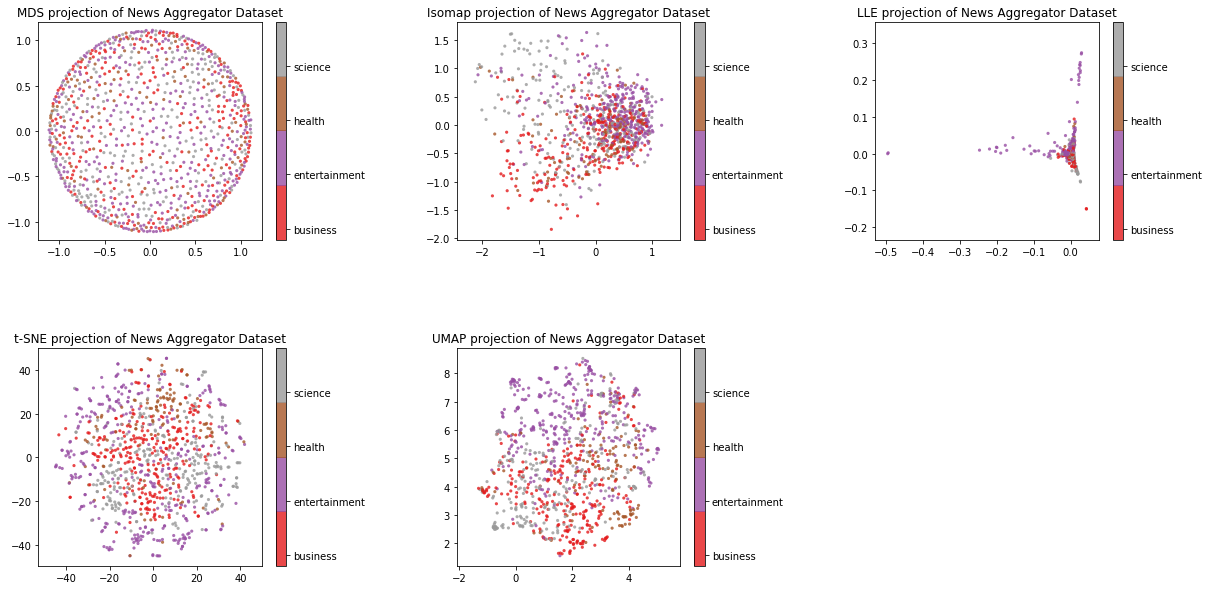

In [82]:
projectors = [embedding_t_mds, emb_isomap_t, emb_lle_t, emb_tsne_t, emb_umap]
plt.rcParams["image.cmap"] = "Set1"
names = ['MDS', 'Isomap', 'LLE', 't-SNE', 'UMAP']
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
plt.subplots_adjust(wspace = 0.5)
plt.subplots_adjust(hspace = 0.5)

i = 1
for proj in projectors:
    ax = fig.add_subplot(2, 3, i)
    plt.scatter(proj[:, 0], proj[:, 1], 
            c=colors, 
            edgecolor='none', 
            alpha=0.80, 
            s=10)
    plt.gca().set_aspect('equal', 'datalim')
    cbar = plt.colorbar(boundaries=np.arange(5)-0.2)
    cbar.set_ticks(np.arange(4))
    cbar.set_ticklabels(['business', 'entertainment', 'health', 'science'])
    tlt = names[i-1] + ' projection of News Aggregator Dataset'
    plt.title(tlt)
    i += 1

#### Метрики качества

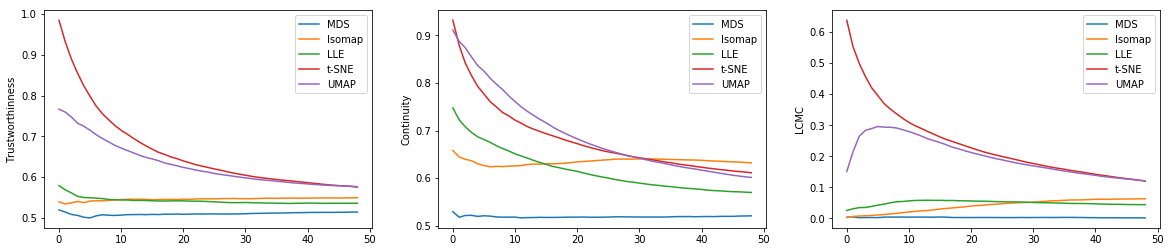

In [58]:
meth =  ['MDS', 'Isomap', 'LLE', 't-SNE', 'UMAP']
plot_metrics(texts_tfidf.toarray(), [embedding_t_mds, emb_isomap_t, emb_lle_t, emb_tsne_t, emb_umap], meth)

#### TMAP

In [81]:
import base64
from io import BytesIO
from timeit import default_timer as timer
from PIL import Image

# Coniguration for the tmap layout
CFG = tm.LayoutConfiguration()
CFG.node_size = 1 / 55

# Initialize and configure tmap
dims = 1024
enc = tm.Minhash(3302, 42, dims)
lf = tm.LSHForest(dims * 2, 128)

# 1. Кодирование объектов
coded = []
for i in range(texts_tfidf.toarray().shape[0]):
    coded.append(tm.VectorFloat(list(texts_tfidf.toarray()[i, :])))

print("Running tmap ...")
start = timer()
lf.batch_add(enc.batch_from_weight_array(coded))
lf.index()
x, y, s, t, _ = tm.layout_from_lsh_forest(lf, CFG)
print("tmap: " + str(timer() - start))

legend_labels = [
    (0, "business"),
    (1, "entertainment"),
    (2, "health"),
    (3, "science"),
]

faerun = Faerun(clear_color="#111111", view="front", coords=False)
faerun.add_scatter(
    "News",
    {"x": x, "y": y, "c": list(colors), "labels": list(colors)},
    colormap="Set1",
    shader="smoothCircle",
    point_scale=2.5,
    max_point_size=10,
    has_legend=True,
    categorical=True,
    legend_labels=legend_labels,
)
faerun.add_tree(
    "News_tree", {"from": s, "to": t}, point_helper="News", color="#666666"
)
faerun.plot("News", template="url_image")

Running tmap ...
tmap: 31.175982300002943


/home/vladimiromelyusik/machine_learning_hse_all/ml_fcs/Project/News.html

### 20 Newsgroups

#### Кодировка с помощью CountVectorizer

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder

In [3]:
dataset = fetch_20newsgroups(subset='test',
                             shuffle=True, random_state=42)

In [25]:
inds = np.random.randint(0, len(dataset.data), 3000)
category_labels = np.array([dataset.target_names[x] for x in dataset.target])[inds].tolist()
labels_num = LabelEncoder().fit_transform(category_labels)

In [26]:
data = np.array(dataset.data)[inds].tolist()

In [27]:
vectorizer = CountVectorizer(min_df=5, stop_words='english')
word_doc_matrix = vectorizer.fit_transform(data)

#### t-SNE

In [28]:
start_time = time.time()
emb_tsne_news = TSNE(n_components = 2).fit_transform(word_doc_matrix.toarray())
dur_tsne_news = time.time() - start_time
print("--- %s seconds ---" % (dur_tsne_news))

--- 222.2053666114807 seconds ---


#### UMAP

In [29]:
start_time = time.time()
emb_umap_news = umap.UMAP(n_neighbors=15).fit_transform(word_doc_matrix)
dur_umap_news = time.time() - start_time
print("--- %s seconds ---" % (dur_umap_news))

--- 6.973668813705444 seconds ---


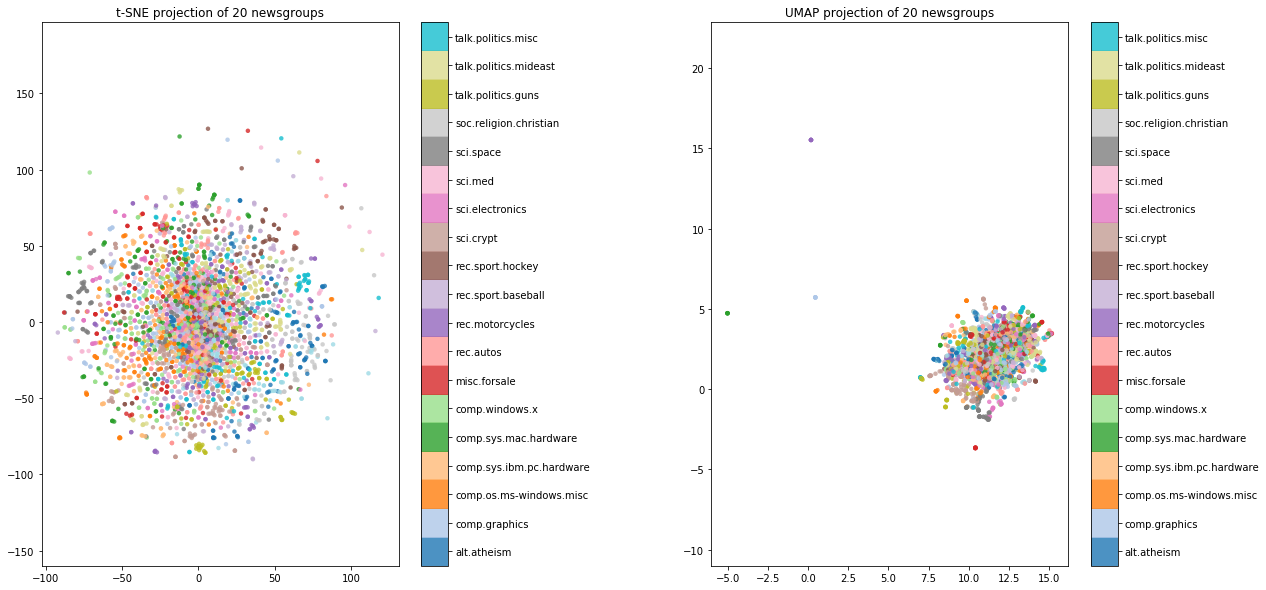

In [61]:
projectors = [emb_tsne_news, emb_umap_news]
names = ['t-SNE', 'UMAP']
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
plt.subplots_adjust(wspace = 0.5)
plt.subplots_adjust(hspace = 0.5)

i = 1
for proj in projectors:
    ax = fig.add_subplot(1, 2, i)
    plt.scatter(proj[:, 0], proj[:, 1], 
            c=labels_num, 
            edgecolor='none', 
            alpha=0.80, 
            s=20)
    plt.gca().set_aspect('equal', 'datalim')
    cbar = plt.colorbar(boundaries=np.arange(20)-0.5)
    cbar.set_ticks(np.arange(20))
    cbar.set_ticklabels(np.unique(category_labels))
    tlt = names[i-1] + ' projection of 20 newsgroups'
    plt.title(tlt)
    i += 1

#### Метрики качества

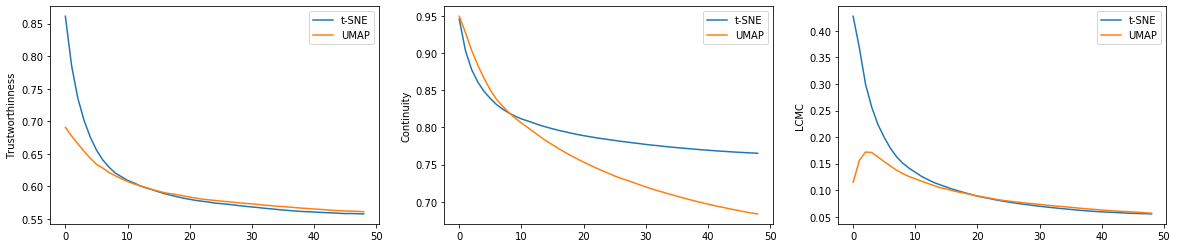

In [48]:
meth =  ['t-SNE', 'UMAP']
plot_metrics(word_doc_matrix.toarray(), [emb_tsne_news, emb_umap_news], meth)